In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import pytorch_lightning as pl
from src.module2 import Transformer
import torch
from src.dm import DFTemporalDataModule

In [78]:
dm = DFTemporalDataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': True,
	'in_channels_s1': 2,
	'in_channels_s2': 3,
    'embed_dim': 256,
	'seq_len': 12,
    'n_heads': 4,
    'num_blocks': 0,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
	# 'scheduler': {
	# 	'OneCycleLR': {
	# 		'max_lr': 1e-3,
	# 		'pct_start': 0.03,
	# 		'total_steps': 300,
	# 		# 'verbose': True
	# 	}
	# }
}

module = Transformer(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=500,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                  | Type           | Params
----------------------------------------------------------
0  | encoder1              | FeatureListNet | 11.2 M
1  | encoder2              | FeatureListNet | 11.2 M
2  | bifpn1                | BiFpn          | 1.0 M 
3  | bifpn2                | BiFpn          | 1.0 M 
4  | fe1                   | ModuleList     | 5.6 M 
5  | fe2                   | ModuleList     | 5.6 M 
6  | query_embedding       | PatchEmbedding | 262 K 
7  | first_attn            | Block          | 790 K 
8  | self_attention_blocks | ModuleList     | 0     
9  | decoder               | ModuleList     | 35.8 K
10 | head                  | Conv2d         | 37

train: 8689
test: 2773


Training: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
dl = dm.train_dataloader(shuffle=False)
s1s, s2s, labels = next(iter(dl))
preds = module.predict(s1s, s2s)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([4, 256, 256]), torch.float32, tensor(2.6175e-05), tensor(0.0690))

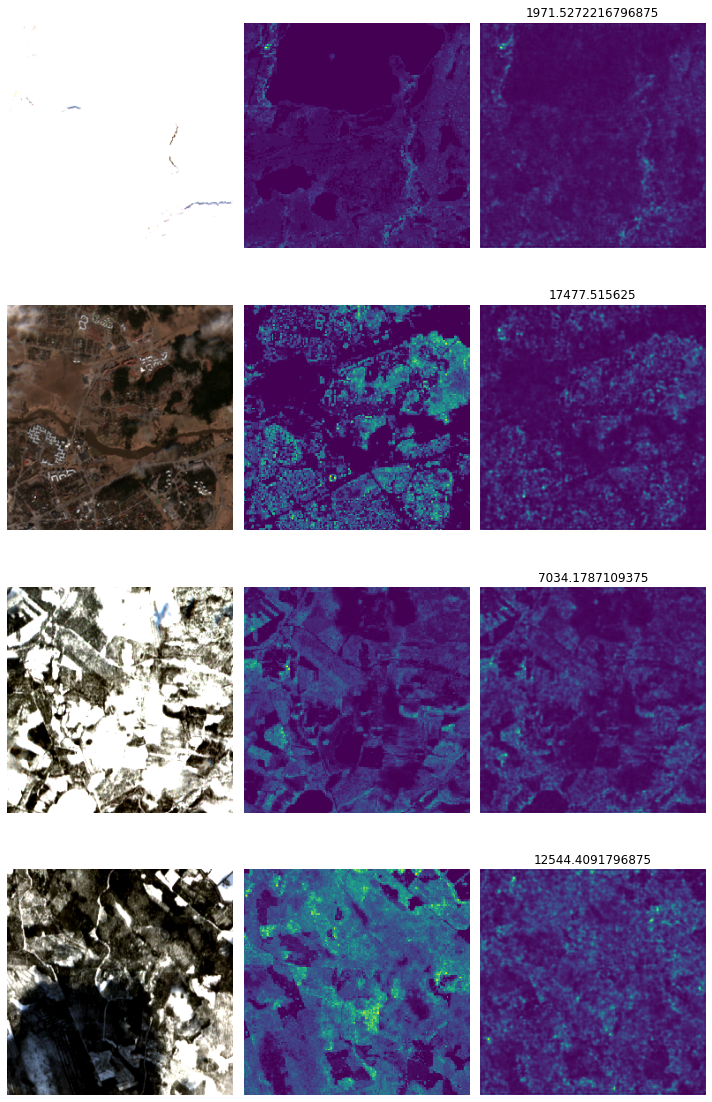

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(s2s[i][-1].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	ax[i, 2].set_title(torch.sqrt(
            torch.sum((preds[i]*12905.3 - labels[i]*12905.3)**2)).item())
plt.tight_layout()
plt.show()

In [2]:
# initialize a raster of the size of the output space
# tile with positional encoding (sin, cos) 
# encode with MLP in a set of query vectors

In [60]:
import torch 

# esto es lo que quiero a la salida (será parámtero y tendrá positional encoding)

a = torch.randn(16, 1, 256, 256)
a.shape

torch.Size([16, 1, 256, 256])

In [61]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [62]:
pe = PatchEmbedding(256, 32, 1, 256)

b = pe(a) # estas son mis queries
b.shape

torch.Size([16, 64, 256])

In [63]:
# cada imagen y multi-scale feature emite su key-value

In [64]:
# con unet

mf = [
    torch.randn(16, 64, 128, 128),
    torch.randn(16, 64, 64, 64),
    torch.randn(16, 128, 32, 32),
    torch.randn(16, 256, 16, 16),
    torch.randn(16, 512, 8, 8)
]

# con bifpn

mf = [
    torch.randn(16, 64, 128, 128),
    torch.randn(16, 64, 64, 64),
    torch.randn(16, 64, 32, 32),
    torch.randn(16, 64, 16, 16),
    torch.randn(16, 64, 8, 8)
]

In [65]:
mes = [
    PatchEmbedding(128, 16, 64, 256),
    PatchEmbedding(64, 8, 64, 256),
    PatchEmbedding(32, 4, 64, 256),
    PatchEmbedding(16, 2, 64, 256),
    PatchEmbedding(8, 1, 64, 256)
]

cs = [me(m) for me, m in zip(mes, mf)]
for c in cs:
    print(c.shape)

c = torch.cat(cs, dim=1)
c.shape

torch.Size([16, 64, 256])
torch.Size([16, 64, 256])
torch.Size([16, 64, 256])
torch.Size([16, 64, 256])
torch.Size([16, 64, 256])


torch.Size([16, 320, 256])

In [66]:
# repetir para serie temporal 
# añadir los correspondientes positional, sensor, etc encodings

c2 = torch.cat([c]*12*2, dim=1)
c2.shape

torch.Size([16, 7680, 256])

In [67]:
from src.attention import Block

block = Block(256, 256)
d = block(c, b)
d.shape

torch.Size([16, 64, 256])

In [68]:
# retrieve image

from einops import rearrange

e = rearrange(d, 'b n (h w) -> b n h w', h=16, w=16)
e.shape

torch.Size([16, 64, 16, 16])

In [69]:
unproj = nn.Sequential(
    nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
    nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
    nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
    nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
    # nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
    nn.Conv2d(4, 1, kernel_size=1, stride=1)
)

f = unproj(e)
f.shape

torch.Size([16, 1, 256, 256])

In [70]:
# con bifpn

mf = [
    torch.randn(16, 64, 128, 128),
    torch.randn(16, 64, 64, 64),
    torch.randn(16, 64, 32, 32),
    torch.randn(16, 64, 16, 16),
    torch.randn(16, 64, 8, 8)
]

In [71]:
mes = [
    PatchEmbedding(128, 8, 64, 64),
    PatchEmbedding(64, 8, 64, 64),
    PatchEmbedding(32, 8, 64, 64),
    PatchEmbedding(16, 8, 64, 64),
    PatchEmbedding(8, 8, 64, 64)
]

cs = [me(m) for me, m in zip(mes, mf)]
for c in cs:
    print(c.shape)

c = torch.cat(cs, dim=1)
c.shape

torch.Size([16, 256, 64])
torch.Size([16, 64, 64])
torch.Size([16, 16, 64])
torch.Size([16, 4, 64])
torch.Size([16, 1, 64])


torch.Size([16, 341, 64])

In [72]:
# con bifpn, si tengo dos sensores, cada sensor tiene 12 imágenes, ...

mf = [
    torch.randn(16, 2, 12, 64, 128, 128),
    torch.randn(16, 2, 12, 64, 64, 64),
    torch.randn(16, 2, 12, 64, 32, 32),
    torch.randn(16, 2, 12, 64, 16, 16),
    torch.randn(16, 2, 12, 64, 8, 8)
]

In [38]:


class MultiscaleFeatureEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = rearrange(x, 'b s l c h w -> b (s l c) h w')
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [39]:
mes = [
    MultiscaleFeatureEmbedding(128, 8, 64*2*12, 64),
    MultiscaleFeatureEmbedding(64, 8, 64*2*12, 64),
    MultiscaleFeatureEmbedding(32, 8, 64*2*12, 64),
    MultiscaleFeatureEmbedding(16, 8, 64*2*12, 64),
    MultiscaleFeatureEmbedding(8, 8, 64*2*12, 64)
]

cs = [me(m) for me, m in zip(mes, mf)]
for c in cs:
    print(c.shape)

torch.Size([16, 256, 64])
torch.Size([16, 64, 64])
torch.Size([16, 16, 64])
torch.Size([16, 4, 64])
torch.Size([16, 1, 64])
